Installing all needed libraries

In [ ]:
%pip install numpy
%pip install pandas
%pip install sklearn
%pip install seaborn

Importing the installed libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sb

Reading and preprocessing the music data 

In [ ]:
data = pd.read_csv('spotify_songs.csv')
data = data[data['language'] == 'en']
data.drop(columns=['language', 'playlist_name', 'playlist_id'], inplace=True)
data = data.drop_duplicates(subset=['track_name', 'track_artist'])
data.reset_index(drop=True, inplace=True)
print(data.columns)
print(data.shape)

Sectioning off data for recommendation subsystems

In [ ]:
lyrics_data = data['lyrics']
energy_data = data[['danceability', 'tempo', 'acousticness']]
mood_data = data[['mode', 'key', 'valence']]

Using cosine similarity and Tfidf for making lyrics comparable

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

lyric_vectorizer = TfidfVectorizer(stop_words='english')
lyrics_data = lyric_vectorizer.fit_transform(lyrics_data)
lyric_similarity_matrix = cosine_similarity(lyrics_data)

Using euclidean distance for making energy and mood comparable

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

energy_difference_matrix = euclidean_distances(energy_data)
mood_difference_matrix = euclidean_distances(mood_data)

Utility functions

In [ ]:
def sort_by_popularity(songs, descending=True):
    if descending:
        return songs.sort_values(by=['track_popularity'])[::-1]
    else:
        return songs.sort_values(by=['track_popularity'])


def get_similar(track_index, count, comparison_matrix, select_smallest):
    similar_songs_indexes = np.argsort(np.array(comparison_matrix[track_index]))
    similar_songs_indexes = np.delete(similar_songs_indexes, np.where(similar_songs_indexes == track_index))
    similar_songs_indexes = similar_songs_indexes[:count] if select_smallest else similar_songs_indexes[::-1][:count]
    return data.iloc[similar_songs_indexes]

# def get_by_era(track_index)

Getters for recommendation subsystems

In [ ]:
def get_by_same_artist(track_index, count):
    return data[data['track_artist'] == data.iloc[track_index]['track_artist']].drop(track_index)[:count]


def get_lyrically_similar(track_index, count):
    return get_similar(track_index, count, lyric_similarity_matrix, False)


def get_energy_similar(track_index, count):
    return get_similar(track_index, count, energy_difference_matrix, True)


def get_mood_similar(track_index, count):
    return get_similar(track_index, count, mood_difference_matrix, True)


def get_random(count):
    return data.sample(count)

Recommendation subsytems

In [ ]:
def recommend_by_same_artist(track_index, count=10, prioritisePopular=True):
    songs_by_same_artist = get_by_same_artist(track_index, count)
    return sort_by_popularity(songs_by_same_artist, prioritisePopular)


def recommend_lyrically_similar(track_index, count=10, prioritisePopular=True):
    similar_songs = get_lyrically_similar(track_index, count)
    return sort_by_popularity(similar_songs, prioritisePopular)


def recommend_energy_similar(track_index, count=10, prioritisePopular=True):
    similar_songs = get_energy_similar(track_index, count)
    return sort_by_popularity(similar_songs, prioritisePopular)


def recommend_mood_similar(track_index, count=10, prioritisePopular=True):
    similar_songs = get_mood_similar(track_index, count)
    return sort_by_popularity(similar_songs, prioritisePopular)


def recommend_random(count=10, prioritisePopular=True):
    random_songs = get_random(count)
    return sort_by_popularity(random_songs, prioritisePopular)

Hybrid recommendation system

In [ ]:
def recommend(track_index, count=10, prioritisePopular=True):
    by_same_artist = recommend_by_same_artist(track_index, count, prioritisePopular)
    lyrically_similar = recommend_lyrically_similar(track_index, count, prioritisePopular)
    energy_similar = recommend_energy_similar(track_index, count, prioritisePopular)
    mood_similar = recommend_mood_similar(track_index, count, prioritisePopular)
    random = recommend_random(count, prioritisePopular)
    # return object how

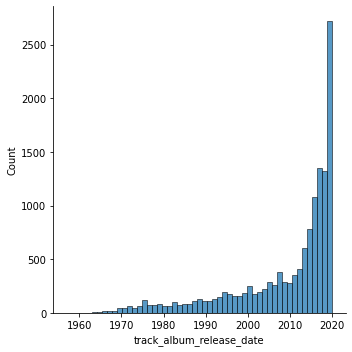

In [50]:
# testing / visualization
data[data['track_artist'] == 'Taylor Swift']

# data.iloc[2274]

data['track_album_release_date'] = pd.to_datetime(data['track_album_release_date'], infer_datetime_format=True)
data['track_album_release_date']
sb.displot(data=data, x='track_album_release_date')
# data[data['track_artist'] == 'Queen'].head(30)
# sonic_data.describe()

# data['track_artist'].value_counts()